In [1]:
import import_helper
import_helper.add_models()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import particle_models.utils as u

### Example analysis of FRAP data
If FRAP is completely due to diffusion of particles, the analytical equation to fit to the recovery curve is (Soumpasis 1983):
\begin{equation}
f(t) = \exp \left( -\frac{\tau}{2t}\right) \left(I_0 \left( \frac{\tau}{2t}\right) + I_1\left(\frac{\tau}{2t}\right) \right)
\end{equation}

where

\begin{equation}
D \propto \frac{w^2}{\tau},
\end{equation}

for 3D diffusion. We use simulation for free space case to obtain the constant of proportionality.

In [2]:
# parameters used for FRAP
Ds = np.array([10, 20, 30, 50, 80]) # diffusion coefficient parameters used
colors = ["red", "orange", "turquoise", "magenta", "purple", "lightpink"] # for plotting
w = 300  # radius of frap in pixels
T = 2000 # total time of frap (depends on simulation)
time_step_ms = 0.4 # time per simulation time step in millisecond

Fitted constant is 9.378057857215905.


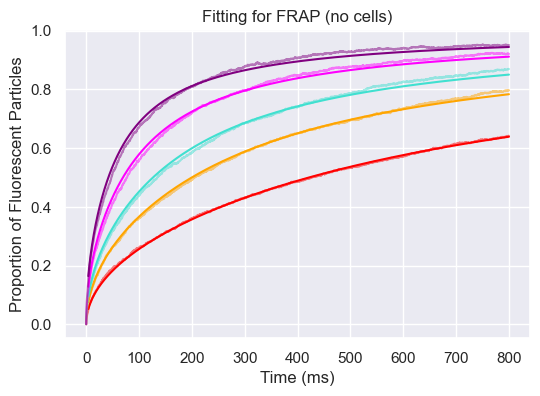

In [3]:
# first fit for free space data
FOLDER_PATH = "../toy_data/frap_data/no_cells"
tau_no_cells = np.zeros_like(Ds)

plt.figure(figsize=(6,4))
for i in range(len(Ds)):
    subfolder = os.path.join(FOLDER_PATH, f"D{Ds[i]}")
    dt = 1 # discretization of simulation time depends on simulations
    time_array = np.arange(0, T+dt, dt)
    if os.path.exists(subfolder):
        intensity = np.zeros(len(time_array))
        intensity[1:], finf = u.get_no_cells_total_frap(subfolder)
        tau_no_cells[i] = u.fit_soumpasis_curve(intensity[5:], time_array[5:])

        # plot the curves to check fitting
        plt.plot(time_array * time_step_ms, intensity, label=f"{Ds[i]}", color=colors[i], alpha=0.5)
        plt.plot(time_array[10:] * time_step_ms, u.soumpasis_function(time_array[10:], tau_no_cells[i], 1), color=colors[i])

plt.title("Fitting for FRAP (no cells)")
plt.xlabel("Time (ms)")
plt.ylabel("Proportion of Fluorescent Particles")

# obtain constant of proportionality
k_no_cell = u.fit_no_cells_case(tau_no_cells, Ds, w)
print(f"Fitted constant is {k_no_cell}.")

Text(0, 0.5, 'Proportion of Fluorescent Particles')

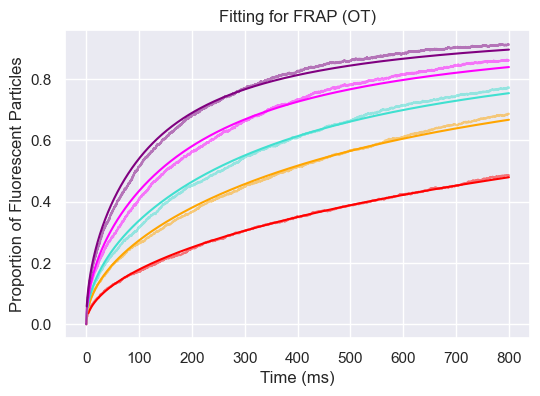

In [4]:
# Now fit for OT case
FOLDER_PATH = "../toy_data/frap_data/ot"
tau_ot = np.zeros_like(Ds)

plt.figure(figsize=(6,4))
for i in range(len(Ds)):
    subfolder = os.path.join(FOLDER_PATH, f"D{Ds[i]}")
    
    if Ds[i] <= 20: # depends on simulation parameters
        dt = 1
    else:
        dt = 20/Ds[i]
    time_steps = int(T/dt) + 1
    time_array = np.linspace(0, T, time_steps)

    if os.path.exists(subfolder):
        intensity = np.zeros(len(time_array))
        intensity[1:], finf = u.get_total_frap (subfolder)
        tau_ot[i] = u.fit_soumpasis_curve(intensity[20:], time_array[20:])

        # plot the curves to check fitting
        plt.plot(time_array * time_step_ms, intensity, label=f"{Ds[i]}", color=colors[i], alpha=0.5)
        plt.plot(time_array[10:] * time_step_ms, u.soumpasis_function(time_array[10:], tau_ot[i], 1), color=colors[i])

plt.title("Fitting for FRAP (OT)")
plt.xlabel("Time (ms)")
plt.ylabel("Proportion of Fluorescent Particles")

Slow down by tortuosity in OT is a factor of 2.0.


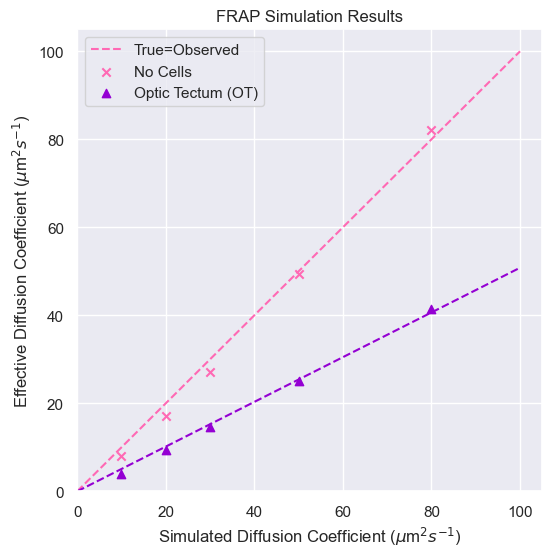

In [5]:
D_eff_no_cells = u.diffusion_coef(tau_no_cells, k_no_cell, w)
D_eff_OT = u.diffusion_coef(tau_ot, k_no_cell, w)
k_ot = u.fit_linear(Ds, D_eff_OT)
print(f"Slow down by tortuosity in OT is a factor of {np.round(1/k_ot, 1)}.")

figure = plt.figure(figsize=(6,6))
D = np.arange(0, 110, 10)

plt.plot(D, D, color="hotpink", linestyle="--", label="True=Observed")
plt.scatter(Ds, D_eff_no_cells, color="hotpink", label="No Cells", marker="x")

plt.plot(D, u.linear(D, k_ot), linestyle="--", color="darkviolet")
plt.scatter(Ds, D_eff_OT, color="darkviolet", label="Optic Tectum (OT)", marker='^')

plt.xlabel(r"Simulated Diffusion Coefficient ($\mu$m$^2$$s^{-1}$)")
plt.ylabel(r"Effective Diffusion Coefficient ($\mu$m$^2$$s^{-1}$)")
plt.title("FRAP Simulation Results")
plt.xlim(0, 100+5)
plt.ylim(0, 100+5)
# plt.ylim(0, max(fitted_d_no_cells[-1], 80)+5)
plt.legend()

### Example analysis of FCS data

d:\YiTing\image_based_particle_model\particle_models\utils.py:358: RuntimeWarning: invalid value encountered in power
  return (G0 * ((1 + (lag_time/tau))**(-1)) * ((1 + (lag_time/tau))**(-1/2)))
d:\YiTing\image_based_particle_model\particle_models\utils.py:358: RuntimeWarning: invalid value encountered in power
  return (G0 * ((1 + (lag_time/tau))**(-1)) * ((1 + (lag_time/tau))**(-1/2)))
d:\YiTing\image_based_particle_model\particle_models\utils.py:358: RuntimeWarning: invalid value encountered in power
  return (G0 * ((1 + (lag_time/tau))**(-1)) * ((1 + (lag_time/tau))**(-1/2)))


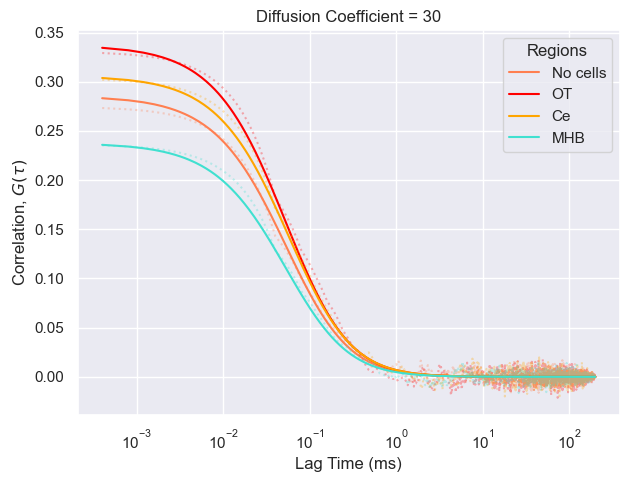

In [6]:
# Analyse data for a "true" diffusion coefficient for all regions
# parameters
D = 30
time_step_ms = 0.4 # time per simulation time step in millisecond

region = ["No cells", "OT", "Ce", "MHB"]
FOLDER = "../toy_data/fcs_data"
files = ['no_cells_D30.csv', 'ot_D30.csv', 'ce_D30.csv', 'mhb_D30.csv']
colors = ["coral", "red", "orange", "turquoise"]

sim_time = np.arange(0, 500, 0.1) # time steps that was run for simulation
fit_time = np.arange(0, 500, 0.1) # total lag time considered for fitting
full_time = np.linspace(0, sim_time[-1], 500000) # for plotting and interpolation

tau = np.zeros(len(region))

fig = plt.figure(figsize=(7,5))
plt.title(f"Diffusion Coefficient = {D}")
plt.ylabel(r"Correlation, $G(\tau)$")
plt.xlabel("Lag Time (ms)")
plt.xscale("log")

for i in range(len(files)):
    file = os.path.join(FOLDER, files[i])

    if os.path.exists(file):
        intensity = pd.read_csv(file)["fcs_region"].to_numpy()
        G0 = 1/np.mean(intensity)
        data = u.autocorr_fcs(intensity)
        data_fit = data[:len(fit_time)]
        fit_params = u.fit_fcs_curve(G0, fit_time, data_fit)
        tau[i] = fit_params
        fitted_curve = u.G(full_time, fit_params, G0)

        data_interp = np.interp(full_time, sim_time, data) # interpolation to plot
        plt.plot(full_time[1:] * time_step_ms, data_interp[1:], color=colors[i], alpha=0.3, linestyle=":")
        plt.plot(full_time[1:] * time_step_ms, fitted_curve[1:], label=f"{region[i]}", color=colors[i])

plt.legend(title=r"Regions")

In [8]:
D_fitted = u.fcs_diffusion_coef(tau, 5)
print(f"Fitted diffusion for {region} cases are {D_fitted}.")

Fitted diffusion for ['No cells', 'OT', 'Ce', 'MHB'] cases are [31.12588941 31.24449345 28.86157326 31.36293897].
